In [1]:
import cv2

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import os


base_dir = 'D:\\food_dataset\\food_dataset'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test')


train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    )
batchsize = 30

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (320,200),
                    batch_size = batchsize,
                    )

validation_generator = val_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (320,200),
                    batch_size = batchsize,
                    )



Found 4200 images belonging to 6 classes.
Found 1200 images belonging to 6 classes.


In [3]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(320, 200, 3))



conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 50, 128)       0     

In [4]:
from keras import models
from keras import layers
from tensorflow import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 6, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dropout (Dropout)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 18,655,622
Trainable params: 18,655,622
No

In [6]:
print('trainable weights: ', len(model.trainable_weights))
conv_base.trainable = True


f = False 
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        f = True
    if f == True:
        layer.trainable = True
    else:
        layer.trainable = False

print('trainable weights: ', len(model.trainable_weights))

trainable weights:  32
trainable weights:  24


In [7]:
import keras
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau( # 不再改善时降低学习率
        monitor='loss',
        factor=0.5,
        patience=2,
    ),
    keras.callbacks.EarlyStopping( # 不再改善时中断训练
        monitor='loss',
        patience=5,
    )
]

In [8]:
from tensorflow import optimizers

model.compile(optimizer=optimizers.SGD(lr=1e-2),
                loss='categorical_crossentropy',
                metrics=['acc'])

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=4200/batchsize,
                    epochs=300,
                    validation_data=validation_generator,
                    validation_steps=1200/batchsize,
                    callbacks = callbacks_list)


d:\python3.8\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\Nickelth\AppData\Local\Temp\ipykernel_14984\3244846159.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/300
140/140 [==============================] - 90s 579ms/step - loss: 1.7533 - acc: 0.2455 - val_loss: 1.6887 - val_acc: 0.2708 - lr: 0.0100
Epoch 2/300
140/140 [==============================] - 81s 578ms/step - loss: 1.4715 - acc: 0.4000 - val_loss: 1.0979 - val_acc: 0.5550 - lr: 0.0100
Epoch 3/300
140/140 [==============================] - 82s 583ms/step - loss: 1.2959 - acc: 0.4988 - val_loss: 1.6153 - val_acc: 0.4875 - lr: 0.0100
Epoch 4/300
140/140 [==============================] - 78s 556ms/step - loss: 1.1047 - acc: 0.5852 - val_loss: 0.6899 - val_acc: 0.7583 - lr: 0.0100
Epoch 5/300
140/140 [==============================] - 81s 578ms/step - loss: 0.9276 - acc: 0.6712 - val_loss: 1.0289 - val_acc: 0.6683 - lr: 0.0100
Epoch 6/300
140/140 [==============================] - 79s 562ms/step - loss: 0.8105 - acc: 0.7176 - val_loss: 0.8463 - val_acc: 0.6808 - lr: 0.0100
Epoch 7/300
140/140 [==============================] - 78s 555ms/step - loss: 0.7305 - acc: 0.7436 - val_l

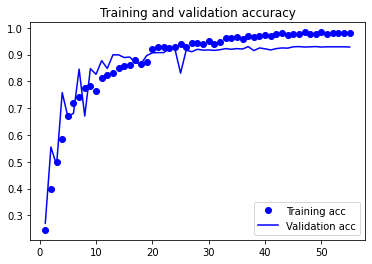

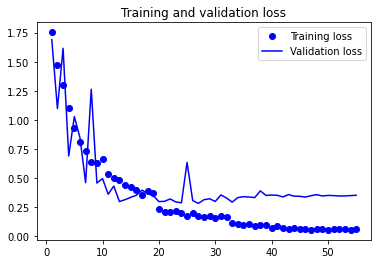

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.save('food_recognize_model6.h5')

In [11]:


test_datagen = ImageDataGenerator(rescale = 1./255)


test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size = (320,200),
                    batch_size =batchsize,
                    )

Found 600 images belonging to 6 classes.


In [12]:
model.evaluate_generator(test_generator)

C:\Users\Nickelth\AppData\Local\Temp\ipykernel_27768\2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.26840177178382874, 0.9316666722297668]